# Sentiment Analysis - US Airline Tweets
by Michele Casalgrandi

### Background
Twitter's large number of active users and posts provides a great source of information.

However, that makes it difficult to quickly detect and respond to negative mentions that could harm the business.  

Sentiment analysis and classification allows companies to respond more effectively to trends and customer concerns.

Data from February of 2015 was scraped and tweets classified as positive, negative or neutral along with a reason (e.g. "late flight").

### Data Dictionary

    tweet_id                                                           
    airline_sentiment                                               
    airline_sentiment_confidence                               
    negativereason                                                   
    negativereason_confidence                                    
    airline                                                                    
    airline_sentiment_gold                                              
    name     
    negativereason_gold 
    retweet_count
    text
    tweet_coord
    tweet_created
    tweet_location 
    user_timezone



In [1]:
# import needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
import string, unicodedata

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# load data
df = pd.read_csv("Tweets.csv")

df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


## Exploratory Data Analysis

In [3]:
print(f"Data set contains {df.shape[0]} rows and {df.shape[1]} columns")

Data set contains 14640 rows and 15 columns


In [4]:
print(len(df['tweet_id'].unique()))

14485


There are some rows with duplicate tweet_id.

In [5]:
# drop duplicates
df = df.drop_duplicates()
df.shape

(14604, 15)

In [6]:
# find number of unique rows
print(len(df['tweet_id'].unique()))

14485


There are still some rows with duplicate tweet_id.  We'll inspect to see if we should consider them as separate tweets.

In [7]:
# should be able to see more of the columns
pd.set_option("max_colwidth", 400)

# get the top rows that have duplicate tweet_id
df[df['tweet_id'].duplicated(keep=False)][['tweet_id','text','airline_sentiment','airline_sentiment_gold']].sort_values(by='tweet_id').head(8)

,tweet_id,text,airline_sentiment,airline_sentiment_gold
12033,569600137296633856,@AmericanAir Thank you.....you do the same!!,positive,positive
14556,569600137296633856,@AmericanAir Thank you.....you do the same!!,positive,NaN
14543,569601363799359488,@AmericanAir should reconsider #usairways acquisition. Flight 1843 AA gold flyers insulted by attendant for hanging jacket!,negative,NaN
12032,569601363799359488,@AmericanAir should reconsider #usairways acquisition. Flight 1843 AA gold flyers insulted by attendant for hanging jacket!,negative,negative
12031,569621879633391616,@AmericanAir no response to DM or email yet. customer service?,negative,negative
14392,569621879633391616,@AmericanAir no response to DM or email yet. customer service?,negative,NaN
14386,569622568459636736,@AmericanAir I want to speak to a human being! !! This is not an obscene request!,negative,NaN
12030,569622568459636736,@AmericanAir I want to speak to a human being! !! This is not an obscene request!,negative,negative


As the text and airline_sentiment are the same, we'll drop rows with duplicate tweet_id.

In [8]:
# drop duplicate tweet_id's 
df = df.drop_duplicates(subset=['tweet_id'], keep='first')

In [9]:
#check new shape
df.shape

(14485, 15)

In [10]:
# check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14485 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14485 non-null  int64  
 1   airline_sentiment             14485 non-null  object 
 2   airline_sentiment_confidence  14485 non-null  float64
 3   negativereason                9082 non-null   object 
 4   negativereason_confidence     10416 non-null  float64
 5   airline                       14485 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14485 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14485 non-null  int64  
 10  text                          14485 non-null  object 
 11  tweet_coord                   1007 non-null   object 
 12  tweet_created                 14485 non-null  object 
 13  t

`tweet_id` is a unique identifier and doesn't add any value for training a model.  We will drop that column.

`airline_sentiment_gold` and `negative_reason_gold` are mostly null.  
We will drop those columns.

In [11]:
# drop columns
df = df.drop(columns=['tweet_id', 'airline_sentiment_gold', 'negativereason_gold'])

In [12]:
df.shape

(14485, 12)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14485 entries, 0 to 14639
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14485 non-null  object 
 1   airline_sentiment_confidence  14485 non-null  float64
 2   negativereason                9082 non-null   object 
 3   negativereason_confidence     10416 non-null  float64
 4   airline                       14485 non-null  object 
 5   name                          14485 non-null  object 
 6   retweet_count                 14485 non-null  int64  
 7   text                          14485 non-null  object 
 8   tweet_coord                   1007 non-null   object 
 9   tweet_created                 14485 non-null  object 
 10  tweet_location                9798 non-null   object 
 11  user_timezone                 9710 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 1.4+ MB


In [14]:
# compare 'tweet_coord','tweet_location','user_timezone' when tweet_coord is null
df[df['tweet_coord'].isna()][['tweet_coord','tweet_location','user_timezone']]

,tweet_coord,tweet_location,user_timezone
0,NaN,NaN,Eastern Time (US & Canada)
1,NaN,NaN,Pacific Time (US & Canada)
2,NaN,Lets Play,Central Time (US & Canada)
3,NaN,NaN,Pacific Time (US & Canada)
4,NaN,NaN,Pacific Time (US & Canada)
...,...,...,...
14635,NaN,NaN,NaN
14636,NaN,Texas,NaN
14637,NaN,"Nigeria,lagos",NaN
14638,NaN,New Jersey,Eastern Time (US & Canada)


`tweet_coord` is null most of the times.  Also `tweet_location` is null most of the time.

#### Tweet Timezone

In [15]:
df['user_timezone'].value_counts().head(10)

Eastern Time (US & Canada)     3720
Central Time (US & Canada)     1900
Pacific Time (US & Canada)     1196
Quito                           724
Atlantic Time (Canada)          494
Mountain Time (US & Canada)     358
Arizona                         226
London                          190
Sydney                          107
Alaska                          106
Name: user_timezone, dtype: int64

<AxesSubplot:ylabel='user_timezone'>

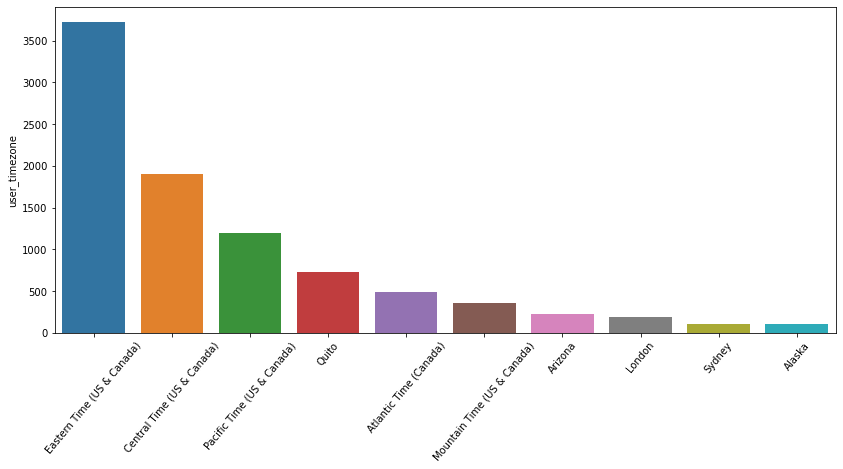

In [16]:
# get counts of timezone
timezone_counts = df['user_timezone'].value_counts().head(10)

plt.figure(figsize=(14,6))
plt.xticks(rotation=50)
# plot 
sns.barplot(x=timezone_counts.index, y=timezone_counts)

#### Tweet Location

Most users were in North America (US and Canada) timezones.  Eastern timezone has the highest count. 

In [17]:
df['tweet_location'].value_counts().head(15)

Boston, MA           156
New York, NY         155
Washington, DC       145
New York             125
USA                  125
Chicago              103
New York City         96
NYC                   93
Los Angeles, CA       93
San Francisco, CA     91
San Francisco         85
Chicago, IL           81
Brooklyn, NY          66
Austin, TX            64
Los Angeles           63
Name: tweet_location, dtype: int64

The majority of users were located in the US at the time of the tweets.

#### Tweets by Airline

In [18]:
# get counts of eac hairline
df['airline'].value_counts()

United            3822
US Airways        2913
American          2604
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:xlabel='airline', ylabel='count'>

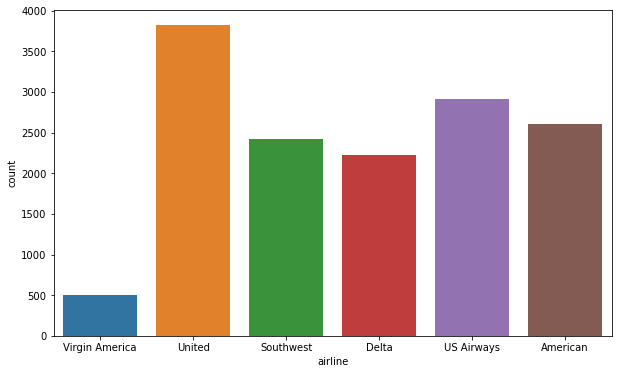

In [19]:
# set up 
plt.figure(figsize=(10,6))

# plot distribution by airline
sns.countplot(x=df['airline'])

United has the highest count of tweets.  Southwest, Delta, US Airways and American have similar counts.

#### Sentiment distribution

<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

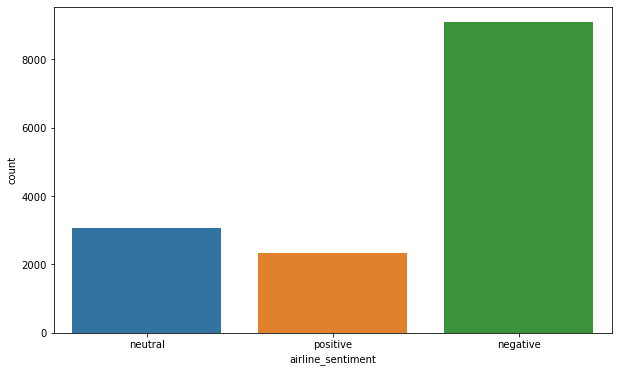

In [20]:
# sentiment distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='airline_sentiment')

* The majority of comments are negative
* The class is imbalanced

In [21]:
total = df.shape[0]
neg_count = df['airline_sentiment'][df['airline_sentiment'] == 'negative'].count()
pos_count = df.airline_sentiment[df.airline_sentiment == 'positive'].count()
neut_count = df.airline_sentiment[df.airline_sentiment == 'neutral'].count()
print(f'Negative sentiment {round (100 * neg_count/total, 3)}% (', neg_count,')')
print(f'Positive sentiment {round (100 * pos_count/total, 3)}% (', pos_count,')')
print(f'Neutral sentiment {round (100 * neut_count/total, 3)}% (', neut_count,')')

Negative sentiment 62.699% ( 9082 )
Positive sentiment 16.113% ( 2334 )
Neutral sentiment 21.187% ( 3069 )


#### Sentiment by Airline

<AxesSubplot:xlabel='airline', ylabel='count'>

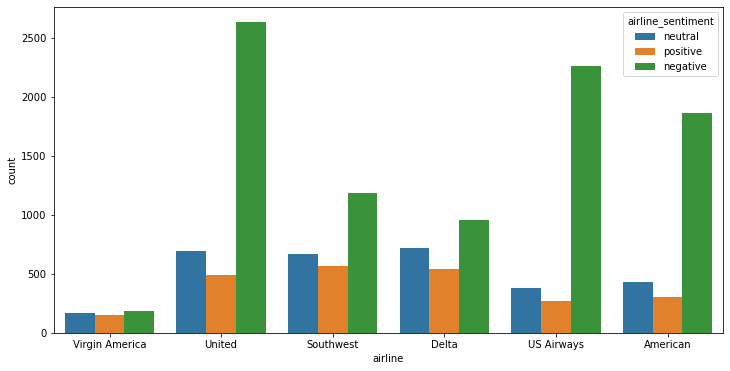

In [22]:
# get sentiment by airline
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='airline', hue='airline_sentiment')

United, US Airways and American have the highest number of negative comments

#### Negative Reasons Distribution

In [23]:
df['negativereason'].value_counts()

Customer Service Issue         2885
Late Flight                    1650
Can't Tell                     1176
Cancelled Flight                829
Lost Luggage                    719
Bad Flight                      575
Flight Booking Problems         523
Flight Attendant Complaints     475
longlines                       177
Damaged Luggage                  73
Name: negativereason, dtype: int64

<AxesSubplot:xlabel='negativereason', ylabel='count'>

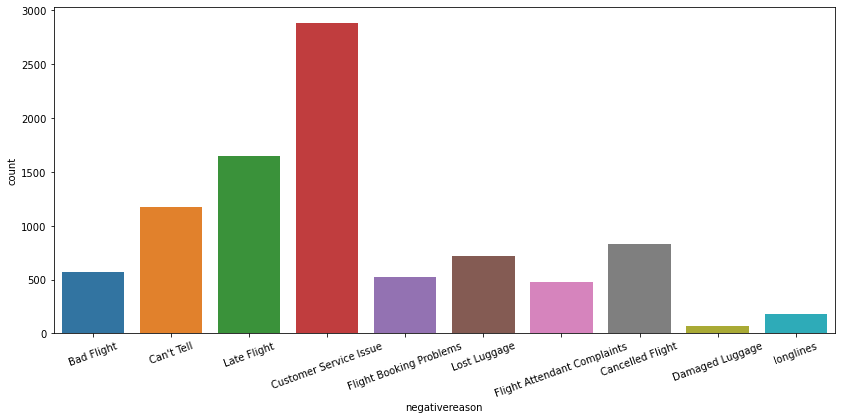

In [24]:
plt.figure(figsize=(14,6))
plt.xticks(rotation=20)
sns.countplot(data=df, x='negativereason')

The most frequent reason for negative sentiment is 'Customer Service Issue' followed by 'Late Flight'

#### Word clouds for positive and negative tweets

In [25]:
import wordcloud

# define function to plot word cloud
def show_wordcloud(series, title, stopwords=None):
    text = ' '.join(series.astype(str).tolist())                 # Converting Summary column into list
    if stopwords != None:
        removed_words = set(stopwords)
#         print("show_wordcloud: stopwords:", len(stopwords))
#     print("show_wordcloud: removed_words:", len(removed_words))
    else:
        removed_words = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=removed_words,background_color='white',          # Setting the different parameter of stopwords
                    colormap='viridis', width=800, height=600, collocations=False).generate(text)
    
    plt.figure(figsize=(14,11), frameon=True)                             
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

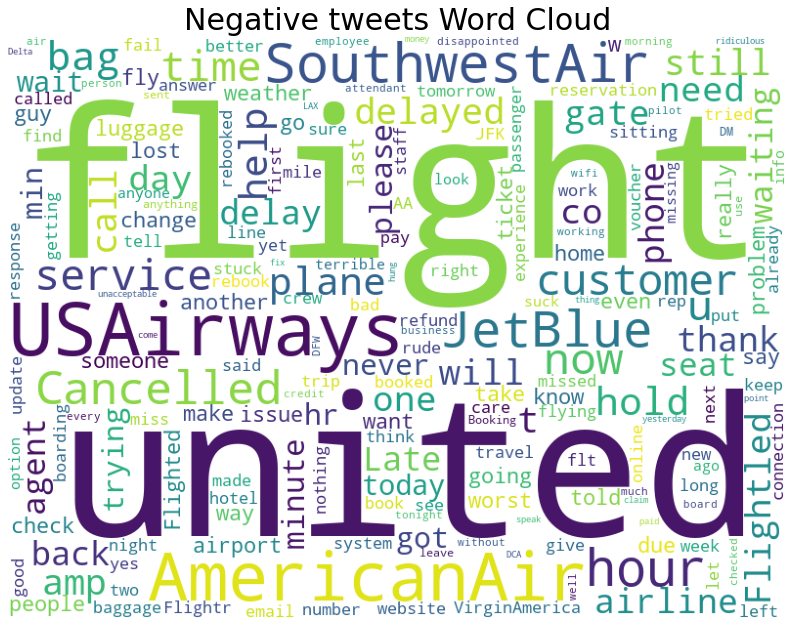

In [26]:
show_wordcloud(df['text'][df['airline_sentiment'] == 'negative'], 'Negative tweets Word Cloud')

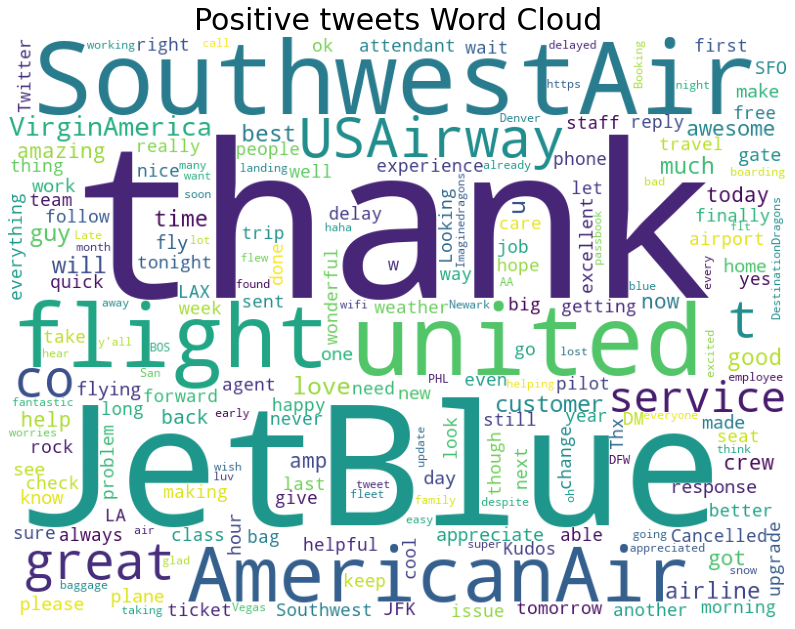

In [27]:
show_wordcloud(df['text'][df['airline_sentiment'] == 'positive'], 'Positive tweets Word Cloud')

## Data Preparation and Pre-processing

In [28]:
# use only sentiment and text for modeling
corpus = df[['text', 'airline_sentiment']]
print('Shape', corpus.shape)
corpus.head(10)

Shape (14485, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,negative
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",positive
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",positive


In [29]:
# query text based on the content
df['text'][df['text'].str.contains('<')].head(10)

Series([], Name: text, dtype: object)

#### HTML tag removal

In [30]:
from bs4 import BeautifulSoup

# make a copy 
corpus_pp = corpus.copy()
print('before', df.shape, corpus.shape, corpus_pp.shape)

for idx, doc in enumerate(corpus_pp['text']):
    soup = BeautifulSoup(doc, 'html.parser')
    tags_removed = soup.get_text()
    corpus_pp['text'].iloc[idx] = tags_removed
    
print('after:', corpus_pp.shape)
corpus_pp['text'].head(10)

before (14485, 12) (14485, 2) (14485, 2)
after: (14485, 2)


0                                                                                                         @VirginAmerica What @dhepburn said.
1                                                                    @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                     @VirginAmerica I didn't today... Must mean I need to take another trip!
3                  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
4                                                                                     @VirginAmerica and it's a really big bad thing about it
5    @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6                                                             @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
7     

#### Remove contractions

In [31]:
import contractions

# remove contractions
corpus_pp['text'] = corpus_pp['text'].apply(contractions.fix, )

# check content
corpus_pp['text'].head(10)

0                                                                                                           @VirginAmerica What @dhepburn said.
1                                                                    @VirginAmerica plus you have added commercials to the experience... tacky.
2                                                                      @VirginAmerica I did not today... Must mean I need to take another trip!
3                   @VirginAmerica it is really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
4                                                                                      @VirginAmerica and it is a really big bad thing about it
5    @VirginAmerica seriously would pay $30 a flight for seats that did not have this playing.\nit is really the only bad thing about flying VA
6                                                            @VirginAmerica yes, nearly every time I fly VX this “ear worm” will not go 

#### Tokenization

In [32]:
from nltk import word_tokenize, wordpunct_tokenize

# tokenize
corpus_pp['text'] = corpus_pp['text'].apply(wordpunct_tokenize)

# check content
corpus_pp['text'].head(10)

0                                                                                                                               [@, VirginAmerica, What, @, dhepburn, said, .]
1                                                                                  [@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]
2                                                                                 [@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]
3                       [@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ", entertainment, ", in, your, guests, ', faces, &, they, have, little, recourse]
4                                                                                                       [@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]
5    [@, VirginAmerica, seriously, would, pay, $, 30, a, flight, for, seats, that, did, not, have, this, playing, ., it, is, 

#### Remove Numbers, Special Characters and Punctuation

In [34]:
# define function to keep only alphabetic character
import re

def remove_non_ascii(tokenized_doc):
    regex = r'[^a-zA-Z]'
    txt = [re.sub(regex, '', word) for word in tokenized_doc]
    txt = [word for word in txt if word != '']
    return txt

# apply function to corpus
corpus_pp['text'] = corpus_pp['text'].apply(remove_non_ascii)

# check content
corpus_pp['text'].head(10)

0                                                                                                                           [VirginAmerica, What, dhepburn, said]
1                                                                                [VirginAmerica, plus, you, have, added, commercials, to, the, experience, tacky]
2                                                                               [VirginAmerica, I, did, not, today, Must, mean, I, need, to, take, another, trip]
3                         [VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]
4                                                                                             [VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]
5    [VirginAmerica, seriously, would, pay, a, flight, for, seats, that, did, not, have, this, playing, it, is, really, the, only, bad, thing, about, flying, VA]
6                           

#### Change to lowercase

In [35]:
# define function to convert to lowercase
def to_lowercase(tokenized_doc):
    txt = [word.lower() for word in tokenized_doc]
    return txt

# convert to lowercase
corpus_pp['text'] = corpus_pp['text'].apply(to_lowercase)
corpus_pp['text'].head(10)

0                                                                                                                           [virginamerica, what, dhepburn, said]
1                                                                                [virginamerica, plus, you, have, added, commercials, to, the, experience, tacky]
2                                                                               [virginamerica, i, did, not, today, must, mean, i, need, to, take, another, trip]
3                         [virginamerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]
4                                                                                             [virginamerica, and, it, is, a, really, big, bad, thing, about, it]
5    [virginamerica, seriously, would, pay, a, flight, for, seats, that, did, not, have, this, playing, it, is, really, the, only, bad, thing, about, flying, va]
6                           

#### Remove Stopwords

In [36]:
import nltk

# get list of stopwords
stopword_list_eng = nltk.corpus.stopwords.words('english')

# keep not to capture negative sentences
stopword_list_eng.remove('not')

# remove url prefixes
stopword_list_eng.append(['http', 'https'])

# function to remove stopwords from the list of tokenized words.
def remove_stopwords(tokenized_doc):
    txt = [word for word in tokenized_doc if word not in stopword_list_eng]
    return txt

# remove stopwords
corpus_pp['text'] = corpus_pp['text'].apply(remove_stopwords)

# check content
corpus_pp['text'].head(10)

0                                                                          [virginamerica, dhepburn, said]
1                                             [virginamerica, plus, added, commercials, experience, tacky]
2                                       [virginamerica, not, today, must, mean, need, take, another, trip]
3    [virginamerica, really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]
4                                                                 [virginamerica, really, big, bad, thing]
5      [virginamerica, seriously, would, pay, flight, seats, not, playing, really, bad, thing, flying, va]
6                             [virginamerica, yes, nearly, every, time, fly, vx, ear, worm, not, go, away]
7    [virginamerica, really, missed, prime, opportunity, men, without, hats, parody, https, co, mwpggrezp]
8                                                                               [virginamerica, well, not]
9                                    

#### Lemmatize

In [37]:
# use wordnet lemmatizer
lemmatizer = nltk.wordnet.WordNetLemmatizer()

# function to lemmatize the words from the list of tokenized words.
def get_lemma(tokenized_doc):
    txt = [lemmatizer.lemmatize(word) for word in tokenized_doc]
    return txt

# lemmatize the corpus
corpus_pp['text'] = corpus_pp['text'].apply(get_lemma)

# check content
corpus_pp['text'].head(10)

0                                                                        [virginamerica, dhepburn, said]
1                                            [virginamerica, plus, added, commercial, experience, tacky]
2                                     [virginamerica, not, today, must, mean, need, take, another, trip]
3    [virginamerica, really, aggressive, blast, obnoxious, entertainment, guest, face, little, recourse]
4                                                               [virginamerica, really, big, bad, thing]
5     [virginamerica, seriously, would, pay, flight, seat, not, playing, really, bad, thing, flying, va]
6                           [virginamerica, yes, nearly, every, time, fly, vx, ear, worm, not, go, away]
7    [virginamerica, really, missed, prime, opportunity, men, without, hat, parody, http, co, mwpggrezp]
8                                                                             [virginamerica, well, not]
9                                                   [vi

In [38]:
# convert tokenized list back to a string
corpus_pp['text'] = corpus_pp['text'].apply(' '.join)

# check content
corpus_pp.head(10)

,text,airline_sentiment
0,virginamerica dhepburn said,neutral
1,virginamerica plus added commercial experience tacky,positive
2,virginamerica not today must mean need take another trip,neutral
3,virginamerica really aggressive blast obnoxious entertainment guest face little recourse,negative
4,virginamerica really big bad thing,negative
5,virginamerica seriously would pay flight seat not playing really bad thing flying va,negative
6,virginamerica yes nearly every time fly vx ear worm not go away,positive
7,virginamerica really missed prime opportunity men without hat parody http co mwpggrezp,neutral
8,virginamerica well not,positive
9,virginamerica amazing arrived hour early good,positive


## Vectorize the Data

#### Count Vectorizer

In [39]:
# get vectorizer
#vectorizer = CountVectorizer(input='content', max_features=8000)
vectorizer = CountVectorizer(input='content', max_features=2000)
vectorizer = vectorizer.fit(corpus_pp['text'])

# get vocabulary
vocabulary = vectorizer.vocabulary_
print('vocabulary', len(vocabulary))

# get document-term matrix
dt_matrix = vectorizer.transform(corpus_pp['text'])
print(dt_matrix.shape)

# get features array
features_cv = dt_matrix.toarray()

print(corpus_pp['text'].iloc[0])
print(features_cv[0][:100])
print(features_cv[0].sum())

vocabulary 2000
(14485, 2000)
virginamerica dhepburn said
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2


#### TF-IDF Vectorizer

In [40]:
# tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(input='content', max_features=2000)

# extract matrix
features_tfidf = tfidf_vectorizer.fit_transform(corpus_pp['text']).toarray()

# print(tfidf_vectorizer.inverse_transform(tfidf_dt_matrix))
print(len(tfidf_vectorizer.vocabulary_))

print(corpus_pp['text'].iloc[0])
print(features_tfidf[0][:100])

2000
virginamerica dhepburn said
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


### Model training and predictions

#### Prepare Data

In [41]:
from sklearn.preprocessing import LabelEncoder

# get labels encoded
encoder = LabelEncoder()
y = encoder.fit_transform(corpus_pp['airline_sentiment'])

print(encoder.classes_)

print(y[:10])

['negative' 'neutral' 'positive']
[1 2 1 0 0 0 2 1 2 2]


#### Split Data in Test and Train sets
##### Split data for train and test for each vectorizer


In [42]:

# 
X_train_cv,  X_test_cv, y_train_cv, y_test_cv = train_test_split(features_cv, y, test_size=0.2, stratify=y)
print('train:', X_train_cv.shape, 'test:', X_test_cv.shape)

X_train_tfidf,  X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(features_tfidf, y, test_size=0.2, stratify=y)
print('train:', X_train_tfidf.shape, 'test:', X_test_tfidf.shape)

train: (11588, 2000) test: (2897, 2000)
train: (11588, 2000) test: (2897, 2000)


### Modeling - Count Vectorized Data - XGBoost

In [43]:
# train model on count vectorized features
from xgboost import XGBClassifier

# define model for multi-level classification
model_cv = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softmax', num_class=3 )

# train the model
model_cv.fit(X_train_cv, y_train_cv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [44]:
# check predictions
model_cv.predict(X_train_cv[:10])

array([0, 0, 1, 0, 1, 2, 0, 2, 0, 0], dtype=int64)

In [45]:
# define function to plot confusion matrix
def plot_confusion_matrix(clssf, X, y_actual, threshold=0.5):
  # get predictions from classifier and decode
  val_predict = clssf.predict(X)

  # decode labels
  val_labels = encoder.inverse_transform(y_actual)
  pred_labels = encoder.inverse_transform(val_predict)

  # get confusion matrix
  cm = confusion_matrix(val_labels, pred_labels)

  # get normalized confusion matrix
  cm_norm = confusion_matrix(val_labels, pred_labels, normalize='true')

  # plot confusion matrix
  plt.figure(figsize=(10, 8))

  # add normalized rates and predictions counts
  annotations = np.array([f'{norm}\n({count})' for count, norm in zip(cm.flatten(), np.round(cm_norm,2).flatten())]).reshape((3,3))

  # plot
  ax = sns.heatmap(cm_norm, square=True, annot=annotations, fmt='', xticklabels=encoder.classes_,yticklabels=encoder.classes_, 
                   cbar=False, cmap='coolwarm')
  plt.xticks(rotation=45)

  plt.show()

  print(classification_report(val_labels, pred_labels))

#### Count Vectorizer Model - Confusion Matrix and Classification Report

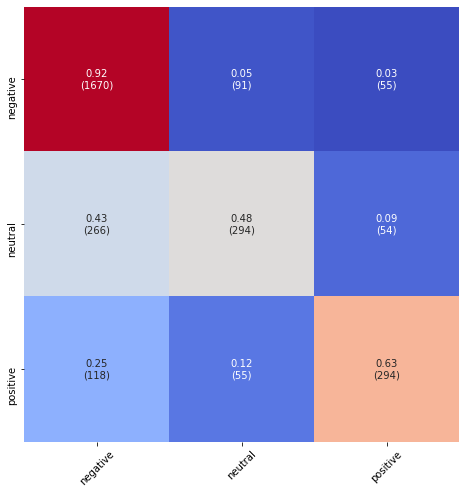

              precision    recall  f1-score   support

    negative       0.81      0.92      0.86      1816
     neutral       0.67      0.48      0.56       614
    positive       0.73      0.63      0.68       467

    accuracy                           0.78      2897
   macro avg       0.74      0.68      0.70      2897
weighted avg       0.77      0.78      0.77      2897



In [46]:
# plot confusion matrix
plot_confusion_matrix(model_cv, X_test_cv, y_test_cv)

* Performance on negative sentiments is high with Precision=0.80 and Recall=0.82
* Performance on neutral sentiments is low with many (0.46) being misclassified as negative
* Overall accuracy is 0.78

In [47]:
# get instance of model for multi-level classification
model_tfidf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softmax', num_class=3 )

# train model on tfidf vectorized features
model_tfidf.fit(X_train_tfidf, y_train_tfidf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

#### TF-IDF Vectorizer Model - Confusion Matrix and Classification Report

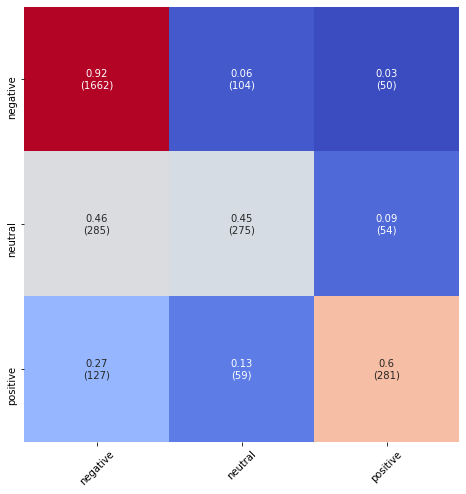

              precision    recall  f1-score   support

    negative       0.80      0.92      0.85      1816
     neutral       0.63      0.45      0.52       614
    positive       0.73      0.60      0.66       467

    accuracy                           0.77      2897
   macro avg       0.72      0.65      0.68      2897
weighted avg       0.75      0.77      0.75      2897



In [48]:
# plot confusion matrix
plot_confusion_matrix(model_tfidf, X_test_tfidf, y_test_tfidf)

* model performance is similar to model using count vectorized data
* no significant gains over count vectorized model

In [49]:
# print how values are encoded for each level
encoder.inverse_transform([0, 1, 2])

array(['negative', 'neutral', 'positive'], dtype=object)

#### Sanity check using VADER sentiment analysis

In [50]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# define class to simulate a model
class sentiment_analyzer():
    def __init__(self, debug=False):
        self.model = SentimentIntensityAnalyzer()
        self.DEBUG = debug
        
    # define function to predict at the document level
    def predict_doc(self, document):
        score = self.model.polarity_scores(document)['compound']
        if self.DEBUG:
            print('Score:', score)
        if score <= -0.05:
            # negative 
            return 0
        elif score >= 0.05:
            # positive
            return 2
        else:
            # neutral
            return 1
    
    def predict(self, features):
        df = pd.DataFrame(features, columns=['text'])
        scores = df['text'].apply(self.predict_doc)
        return scores.to_numpy()

#### VADER performance

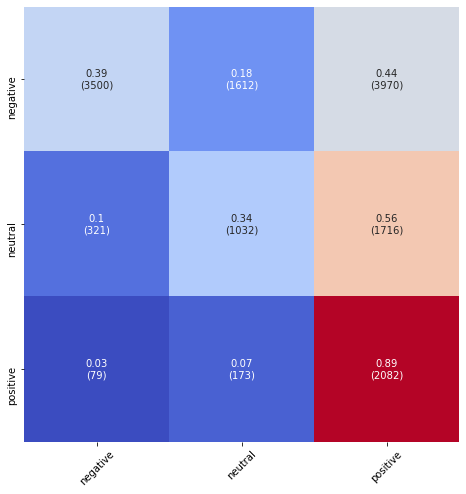

              precision    recall  f1-score   support

    negative       0.90      0.39      0.54      9082
     neutral       0.37      0.34      0.35      3069
    positive       0.27      0.89      0.41      2334

    accuracy                           0.46     14485
   macro avg       0.51      0.54      0.43     14485
weighted avg       0.68      0.46      0.48     14485



In [51]:
# get vader wrapper
model_vader = sentiment_analyzer()

# check performance
plot_confusion_matrix(model_vader, corpus_pp['text'], y)

* VADER has much better True Positive performance (0.89) but low accuracy overall (0.46)
* note that performance was measured against the whole corpus
* positive and neutral performance is on par with random classifier

In [52]:
print(X_train_tfidf.shape, y_train_tfidf.shape)

(11588, 2000) (11588,)


#### Tune the model
(model was trained for 3 hours, commented out to allow notebook to run in reasonable time)

In [53]:
# # get instance of classifier
# xgb_tuned = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softmax', num_class=3)

# # hyperparameters space
# parameters = {
#     'n_estimators': np.arange(40, 200, 5),
#     'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 0.1],
#     'subsample': [0.5, 0.7, 0.9],
# #     'base_estimator': [
# #         DecisionTreeClassifier(max_depth=1, random_state=1),
# #         DecisionTreeClassifier(max_depth=2, random_state=1),
# #         DecisionTreeClassifier(max_depth=3, random_state=1),
# #     ],
# #     'gamma': [0,1,3],
# #     'colsample_bytree': [0.5,0.7,0.9],
# #     'colsample_bylevel':[0.5,0.7,0.9],
# }

# import sklearn.metrics as metrics
# # f1_score_func = metrics.make_scorer(metrics.f1_score, **{'average': None})
# # scorer = lambda y, y_pred, args: np.mean(f1_score_func(y, y_pred, {}))
# # get grid instance
# grid_obj = RandomizedSearchCV(estimator=xgb_tuned, 
#                         param_distributions=parameters,
#                         n_iter=50,
#                         scoring='f1_micro',
#                         cv=5)
# import time
# start_time = time.time()
# print(start_time)

# grid_obj.fit(X_train_tfidf, y_train_tfidf)

# print(f'Elapsed time: {time.time() - start_time}')

In [54]:
# best_model = grid_obj.best_estimator_

In [55]:
# plot_confusion_matrix(best_model, X_test_tfidf, y_test_tfidf)

##### Tuned model performance 
RandomizedSearchCV took almost three hours to train.  
The performance overall was accuracy of 0.77 but neutral sentiments were often misclassified as Negative (47%).  
Only 57% of positive sentiments were classified correctly.  

Code is commented out to avoid the long training time when rerunning the notebook.

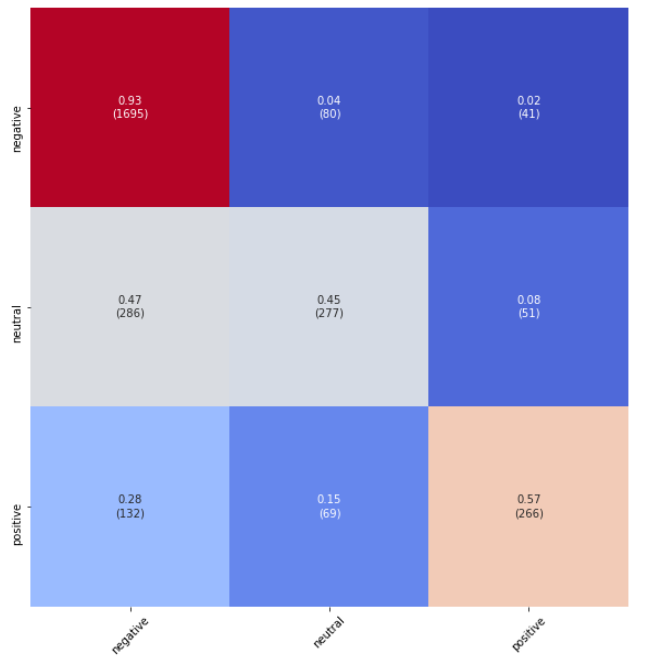

### Model using Random Forest Classifier

In [57]:
# use Random forest classifier
from sklearn.ensemble import RandomForestClassifier
import time

# get instance and use class_weight
model_rf = RandomForestClassifier(class_weight='balanced')

# timestamp
start_time = time.time()
print('Start', time.ctime())

# train the model
model_rf.fit(X_train_tfidf, y_train_tfidf)

print(time.ctime())
print(f'Elapsed time: {time.time() - start_time}')
print('Stop', time.ctime())

Start Fri Nov 12 19:17:42 2021
Fri Nov 12 19:18:04 2021
Elapsed time: 22.62061357498169
Stop Fri Nov 12 19:18:04 2021


#### TF-IDF Vectorizer Model - Random Forest Confusion Matrix and Classification Report

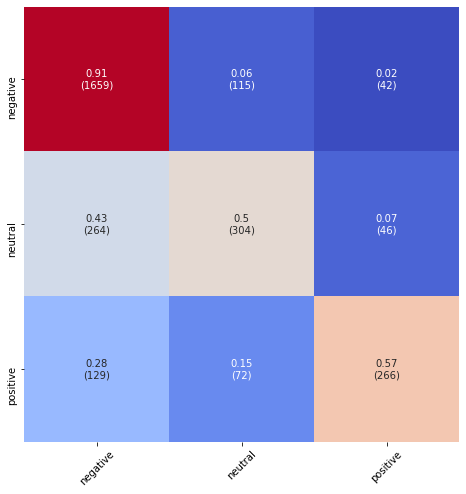

              precision    recall  f1-score   support

    negative       0.81      0.91      0.86      1816
     neutral       0.62      0.50      0.55       614
    positive       0.75      0.57      0.65       467

    accuracy                           0.77      2897
   macro avg       0.73      0.66      0.69      2897
weighted avg       0.76      0.77      0.76      2897



In [58]:
# plot confusion matrix
plot_confusion_matrix(model_rf, X_test_tfidf, y_test_tfidf)

* Accuracy is 0.76
* True Negative Rate 0.9
* Model is overfit for True neutral and True positive

#### Tune Random Forest Model

Change min_samples_leaf to 10 (default 1) to reduce overfitting.

In [59]:
# prune the tree
model_rf2 = RandomForestClassifier(min_samples_leaf=10, class_weight='balanced')
start_time = time.time()
print('Start', time.ctime())

model_rf2.fit(X_train_tfidf, y_train_tfidf)

print('Stop', time.ctime())
print(f'Elapsed time: {time.time() - start_time}')

Start Fri Nov 12 20:11:00 2021
Stop Fri Nov 12 20:11:15 2021
Elapsed time: 14.585662364959717


#### Random Forest tuned Confusion Matrix and Classification Report

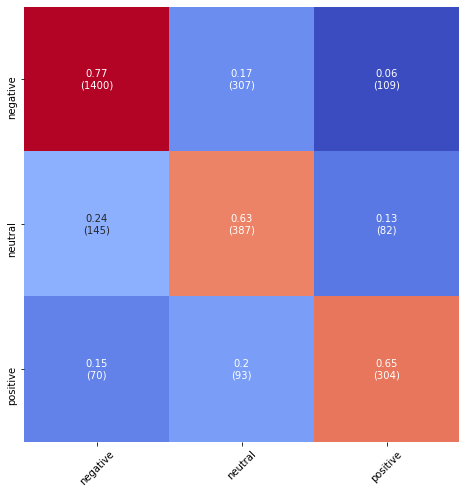

              precision    recall  f1-score   support

    negative       0.87      0.77      0.82      1816
     neutral       0.49      0.63      0.55       614
    positive       0.61      0.65      0.63       467

    accuracy                           0.72      2897
   macro avg       0.66      0.68      0.67      2897
weighted avg       0.75      0.72      0.73      2897



In [60]:
plot_confusion_matrix(model_rf2, X_test_tfidf, y_test_tfidf)

Performance of the Random Forest model with min_samples_leaf = 10 is improved with regards to misclassification.  
Although the precision dropped to 0.73 from 0.76, there are fewer misclassified neutral and positive sentiments.

If more weight is given to correctly classifying negative sentiments, the initial model is more accurate for negative sentiment classification (True Negative = 0.92).

### Features importances

#### Top 40 features - TF-IDF vectorizer

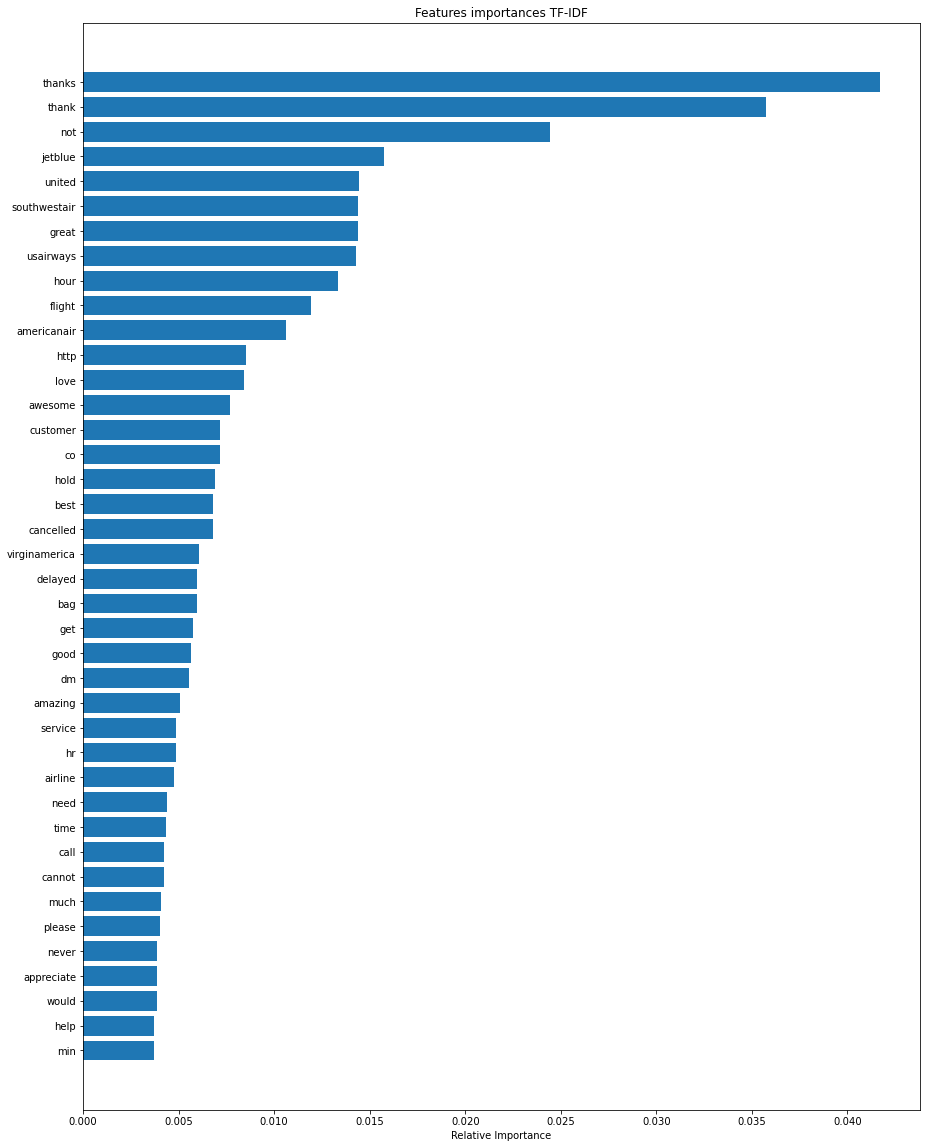

In [61]:
# get features importances
features_importances = model_rf.feature_importances_

#print(features_importances[:10])

# get only the top 40 features
sorted_indexes  = np.argsort(features_importances)[-40:]
# print('sorted', features_importances[sorted_indexes][:10])

feature_names = tfidf_vectorizer.get_feature_names()
top40_features = [feature_names[i] for i in sorted_indexes]
# print(top40_features)

# plot sorted by importance
plt.figure(figsize=(15, 20))
plt.title('Features importances TF-IDF')
plt.barh(range(len(sorted_indexes)), features_importances[sorted_indexes], align='center')
plt.yticks(range(len(sorted_indexes)), top40_features)
plt.xlabel('Relative Importance')
plt.show()

* The top three words for count vectorizer modeling are `thank`, `thanks` and `not`

#### Word Cloud - TF-IDF top 40 features

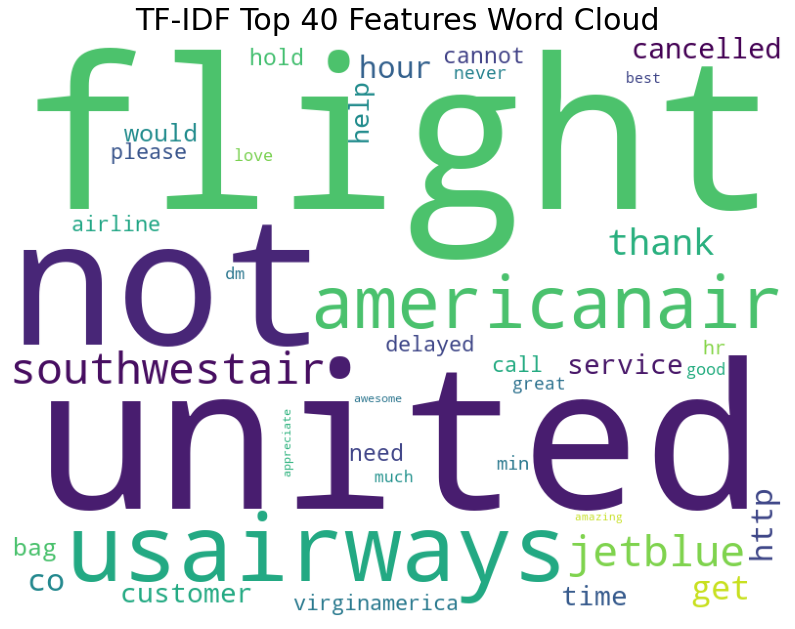

In [62]:
# get vocabulary of corpus
vectorizer_full = TfidfVectorizer(input='content')
vectorizer_full.fit(corpus_pp['text'])
vocabulary = set(vectorizer_full.vocabulary_.keys())
#print('vocabulary',len(vocabulary))

# words to be ignored in the word cloud
ignored_words = vocabulary.difference(set(top40_features))

# print(ignored_words)
#print(set(top40_features))

# hack to remove single letters form word cloud
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
ignored_words = ignored_words.union(alphabet)

#print('Ignored', len(ignored_words))

# print(corpus_pp['text'].iloc[:10])
# print('Top 40 words', vocabulary.difference(ignored_words))

# word cloud
show_wordcloud(corpus_pp['text'], 'TF-IDF Top 40 Features Word Cloud', stopwords=ignored_words)

#### Count Vectorizer Features Importances - Top 40

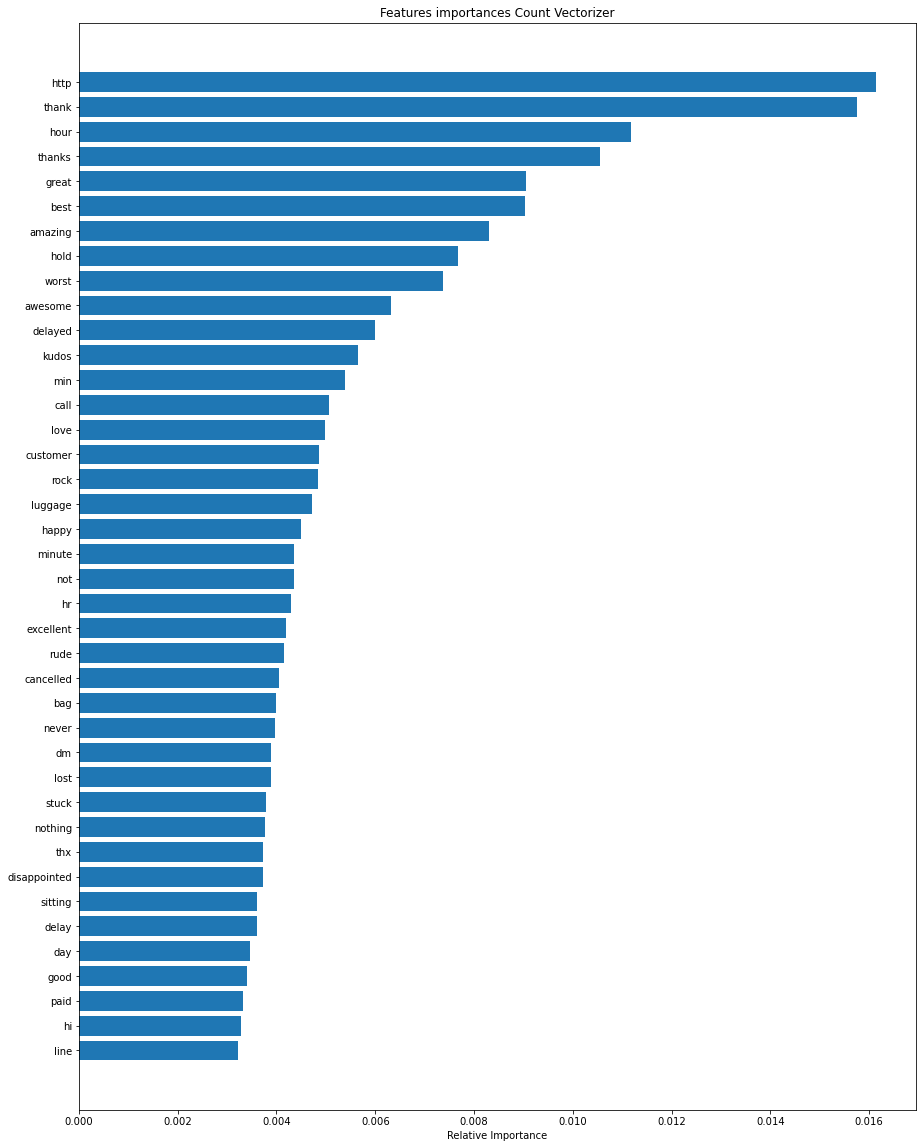

In [63]:
# get features importances
features_importances_cv = model_cv.feature_importances_

#print(features_importances_cv[[999, 1216]])
#print(features_importances_cv[[1246, 1245]])

#print('importances:',features_importances_cv[:10])

# get only the top 40 features
sorted_indexes_cv = np.argsort(features_importances_cv)[-40:]

#print('sorted importances',features_importances_cv[sorted_indexes_cv])
#print('sorted indexes', sorted_indexes_cv[-10:])

# get features names
feature_names_cv = vectorizer.get_feature_names()
top40_features_cv = [feature_names_cv[i] for i in sorted_indexes_cv]

#print(top40_features_cv)

# plot sorted by importance
plt.figure(figsize=(15, 20))
plt.title('Features importances Count Vectorizer')
plt.barh(range(len(sorted_indexes_cv)), features_importances_cv[sorted_indexes_cv], align='center')
plt.yticks(range(len(sorted_indexes_cv)), top40_features_cv)
plt.xlabel('Relative Importance')
plt.show()

* The top three words for the model using count vectorized words: `https`, `thank` and `hour`

#### Word Cloud - Count Vectorizer Top 40 features

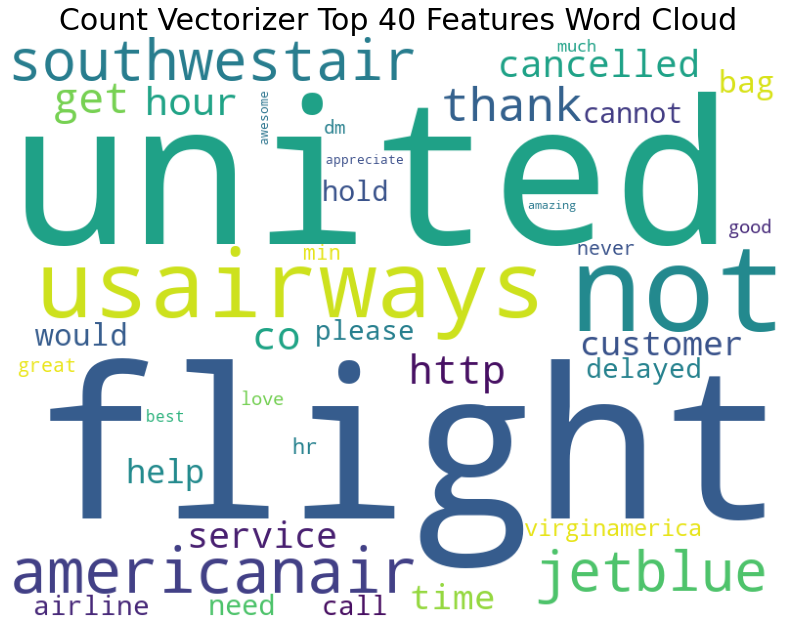

In [64]:
# get words to ignore
ignored_words_cv = vocabulary.difference(set(top40_features_cv))

# print(ignored_words)
# print(set(top40_features))

alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
ignored_words_cv = ignored_words.union(alphabet)

# print('Ignored', len(ignored_words_cv))

# print(corpus_pp['text'].iloc[:10])
# print('Top 40 words', vocabulary.difference(stop_words))

# plot word cloud
show_wordcloud(corpus_pp['text'], 'Count Vectorizer Top 40 Features Word Cloud', stopwords=ignored_words_cv)

## Conclusions
### Preprocessing
* order of preprocessing steps is important for the final content as different order can result in different vocabulary
* HTML tag removal was completed as requested by project guideline but there were no HTML tags in the corpus.  Library used was BeautifulSoup
* contractions were replaced with the spelled out version (e.g. `don't` => `do not`)
* tokenization was completed using nltk wordpunct_tokenize so punctuation is seprated from words
* numbers, punctuation and special characters where removed by removing everything that is not an alphabetical caracter
* text was converted to lowercase using standard Python string methods
* stopwords removal was done using the nltk list of english stopwords with the exception of `not`.   
    `not` was removed from stopwords to prevent phrases with opposite meaning to became the same (e.g. 'I do like' and 'I do not like')
* WordNetLemmatizer was used to lemmatize the corpus

Possible improvements:
* remove urls from text
* remove @username before tokenization so that usernames do not appear in the vocabulary
* words like `thank`, `thanks`, `thx` should be consolidated as part of lemmatization as they carry almost identical meaning
* include bigrams or higher n-grams in tokenization
* do not remove emojies as they convery sentiment

### Vectorization
* the two vectorizations resulted in very similar performance of the XGBoost models
* possible improvements:
    * raise the number of words in the vocabulary (2000 was used) to see if it results in better performance
    * reduce the size of the vocabulary to see if it results in better performance
    * Use other vectorization methods 
    * remove words above a certain count threshold

### Models
* default XGBoost models performance is medium.  Good on True negative but not on neutral and positive classification
* tuning using Randomized Search was slow making tuning difficult.  
    First round of tuning did not improve performance significantly
* default random forest performance was similar to XGBoost but improved with pruning/complexity reduction
* some models had better performance on True negatives while others were better on True positive.  
    As one of the objectives is to quickly identify negative posts so they can be addressed promptly, the former should be preferred 
* improvements
    * do more extensive tuning of the classical models
    * use neural networks to see if a better model can be obtained
    